# Temporal Causal Memory Demo

Introducing explicit temporal modeling into the graph and embedding that temporal context as its own semantic vector nodes could enable even more nuanced retrieval and reasoning. Let’s explore that idea in more detail:

## Conceptual Approach

1. **Time as a First-Class Citizen:**
   Instead of just storing a timestamp as a property on a node, we treat time as a structured entity in the graph. For example, for each piece of content (a message, a code snippet, a document), we create relationships to “time nodes” that represent various granularities of temporal context:
   - **Year/Month/Day Nodes:** Representing calendar dates.
   - **Day of Week Nodes:** Embedding cyclical patterns like weekdays vs. weekends.
   - **Hour/Minute/Second Nodes:** Capturing finer-grained temporal context (morning vs. evening, or even exact second-level events).

   By linking content to these temporal nodes, we can embed time as a semantic dimension directly into our memory graph.

2. **Temporal Embeddings and Patterns:**
   Just as we create embeddings for textual content and relationships, we can create embeddings for these time nodes. For instance:
   - **Time of Day Embeddings:** A 24-dimensional representation, or a continuous sinusoidal embedding (like how positional embeddings in transformers encode sequence position) to represent hours and minutes.
   - **Cyclical Patterns:** Encode day-of-week or time-of-year using sinusoidal patterns, allowing the model to grasp recurrent temporal patterns (e.g., “Monday mornings are associated with certain kinds of queries”).
   - **Time Zones or Seasonal Contexts:** If relevant, nodes could encode seasonal shifts or regional times.

3. **Temporal Edges and Causality Links:**
   With time explicitly modeled, we can start to represent potential causal relationships:
   - If Node A (a conversation turn) precedes Node B (a user request) by a known time interval, we might create edges that reflect temporal proximity.
   - Repeated patterns at similar times of day or week can form clusters of edges that highlight causality or correlation. For example, user tends to ask technical questions late at night or on Mondays. Over time, these patterns form a causal-like structure where certain conditions (time+context) lead to certain types of queries.

4. **Temporal Weighting and Decay:**
   Previously, we used temporal decay as a simple half-life function. With explicit temporal nodes, we can:
   - Consider the distance in the graph along temporal nodes when deciding retrieval: nodes linked to very distant time nodes might be less relevant unless strongly connected or emotionally salient.
   - If we model daily cycles as sinusoidal embeddings, the system can learn that certain memories are more or less relevant depending on the current time. This mirrors a human-like rhythm—some memories feel “closer” if something similar happened recently (or at a similar time in the past).

5. **Causality Modeling:**
   With a rich temporal structure, it’s not just about remembering what happened before, but how often certain sequences occur. If the system notices a pattern:
   - Late at night (time node cluster indicating 11 PM - 1 AM), user often references old code snippets.
   - On Mondays, user is more likely to ask conceptual questions rather than detail-oriented ones.

   The graph could start forming edges that represent these observed correlations:
   - Edges that link temporal conditions (like “Monday morning nodes”) with certain retrieval successes, reinforcing the STDP weighting for methods that worked well at that time.
   - Over time, these patterns form a proto-causal model: “Given it’s Monday morning and the user asked a conceptual question last week at the same time and got a good answer from embedding-based retrieval, we increase the embedding weight today for conceptual queries in this time window.”

6. **Contextual Attention with Time Nodes:**
   Now, attention (or the adaptive weighting mechanism) can also consider these time nodes. When retrieving context:
   - The system can preferentially attend to nodes connected to the current time’s node, or to similar temporal patterns.
   - Emotional nodes from a similar time period last week might remain more accessible if a similar emotional context arises again now.

7. **Use Cases:**
   - **Cyclical events:** If the user has a habit of referencing certain documents every Friday afternoon, the system can learn to preemptively page in those nodes when it detects it’s Friday afternoon again.
   - **Seasonal or Event-Driven Patterns:** If certain code snippets or topics are always discussed around a particular project milestone or season, time nodes help the system remember that pattern.

8. **Technical Implementation Sketch:**
   - Add a “Time Graph” layer, where each node in the main graph (content node) has edges to several time nodes: (:TimeOfDay {hour, minute}), (:DayOfWeek {day}), and possibly (:Date {year, month, day}).
   - Compute embeddings for these time nodes:
     - Day of week could be a learned embedding of dimension D.
     - Time of day could be encoded as two sinusoidal embeddings (for hour and minute) to represent cyclical time.
   - During retrieval, incorporate time embeddings into the similarity score:
     - Weighted sum of content similarity and temporal similarity.
     - Adjust STDP weights or selection strategy based on the observed success at similar times.

This essentially extends the attention mechanism into a spatio-temporal embedding space.

## Summary

By making time an entity in the graph and encoding it as vector nodes with cyclical, hierarchical, and causal patterns, we add a powerful dimension to the memory system. The memory retrieval process can then consider not just semantic and relational aspects, but also temporal proximity and cycles. This sets the stage for building a more advanced model of causality and prediction, enabling the system to anticipate user needs based on when and how memory was accessed in the past, further blurring the lines between a simple retrieval system and a model that “understands” the temporal dimensions of its stored knowledge.

In [1]:

import math, time
import numpy as np
import networkx as nx
from neo4j import GraphDatabase
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Global constants
DECAY_HALF_LIFE = 3600.0
NEO4J_URI = "bolt://localhost:7474"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "your_password"



# Cell 2: Observability class, or define it in a separate cell



# Cell 3: TemporalNode class
# (Embedding hours, days, etc.)


In [2]:
import math
import time
import numpy as np
import networkx as nx
from typing import Dict, Any

DECAY_HALF_LIFE = 3600.0  # Just as an example

class TemporalNode:
    def __init__(self, granularity: str, value: int):
        self.granularity = granularity  # e.g. 'hour', 'day_of_week'
        self.value = value
        self.embedding = self._compute_temporal_embedding()
    
    def _compute_temporal_embedding(self) -> np.ndarray:
        # Examples with sinusoidal encoding
        if self.granularity == 'hour':
            hour_radians = 2 * math.pi * self.value / 24
            return np.array([math.sin(hour_radians), math.cos(hour_radians)])
        elif self.granularity == 'day_of_week':
            day_radians = 2 * math.pi * self.value / 7
            return np.array([math.sin(day_radians), math.cos(day_radians)])
        else:
            # Default: no special encoding
            return np.zeros(2)


# Cell 4: TemporalCausalGraph
## The logic for storing pattern strengths, etc.


In [3]:
import math
import time
import networkx as nx

DECAY_HALF_LIFE = 3600.0  # Example half-life in seconds for time-based weighting

class TemporalCausalGraph(nx.MultiDiGraph):
    """
    A graph structure that stores events (node IDs) and their temporal relationships.
    You can add edges representing that one event tends to follow another within
    a certain time_delta. Over time, recurring patterns are strengthened, allowing
    the graph to predict likely subsequent events for a given context.
    """

    def __init__(self):
        super().__init__()
        # A dictionary for storing observed patterns between nodes
        # Key: "source_id->target_id" (string)
        # Value: { 'strength': float, 'count': int, 'typical_time_delta': float }
        self.temporal_patterns = {}

    def add_temporal_edge(
        self,
        source_id: int,
        target_id: int,
        time_delta: float,
        pattern_strength: float
    ):
        """
        Record an observed temporal edge from source_id to target_id with a given time_delta.
        The 'pattern_strength' is how strongly you believe this transition is relevant.
        
        The method:
        1. Adds an edge with a 'temporal_weight' factor that decays with time_delta.
        2. Updates self.temporal_patterns to strengthen or initialize a pattern for this edge.
        """

        # A weighting factor that decays with time_delta (simple exponential decay)
        temporal_weight = math.exp(-time_delta / DECAY_HALF_LIFE)

        # Build a string key to store pattern data
        pattern_key = f"{source_id}->{target_id}"

        # If we have seen this edge pattern before, update its strength and typical time delta
        if pattern_key in self.temporal_patterns:
            pattern = self.temporal_patterns[pattern_key]
            # Combine old strength and new pattern_strength (simple average or exponential smoothing)
            pattern['strength'] = (pattern['strength'] + pattern_strength) / 2.0
            pattern['count'] += 1
            # Update typical time delta with a running average
            old_count = pattern['count']
            old_avg = pattern['typical_time_delta']
            pattern['typical_time_delta'] = (old_avg * (old_count - 1) + time_delta) / old_count
        else:
            # Initialize a new pattern record
            self.temporal_patterns[pattern_key] = {
                'strength': pattern_strength,
                'count': 1,
                'typical_time_delta': time_delta
            }

        # Add the edge to the graph
        # We store the temporal_weight and the raw time_delta, in case you want to do more analysis
        self.add_edge(
            source_id,
            target_id,
            temporal_weight=temporal_weight,
            time_delta=time_delta,
            pattern_strength=pattern_strength
        )

    def identify_recurring_patterns(
        self,
        minimum_count: int = 3,
        strength_threshold: float = 0.5
    ):
        """
        Return a subset of patterns that appear to recur frequently or strongly.

        :param minimum_count: The minimum number of times we've observed this pattern
                              for it to be considered recurring.
        :param strength_threshold: The minimum average strength required for the pattern
                                   to be considered meaningful.
        :return: A dictionary of pattern_key -> pattern_data that meets the criteria.
        """
        recurring = {}
        for pattern_key, pattern_data in self.temporal_patterns.items():
            if (pattern_data['count'] >= minimum_count and
                pattern_data['strength'] >= strength_threshold):
                recurring[pattern_key] = pattern_data
        return recurring

    def predict_likely_nodes(
        self,
        current_time: float,
        temporal_context: dict,
        top_k: int = 5
    ):
        """
        A placeholder method for predicting which nodes are likely relevant next,
        based on the recurring patterns stored in self.temporal_patterns and
        an optional `temporal_context`.

        :param current_time: The current time (epoch or relative).
        :param temporal_context: Additional info about the context, e.g. 'hour', 'day_of_week'.
        :param top_k: How many node IDs to return as top predictions.
        :return: A list of node IDs predicted to be relevant.
        """

        # Example usage of identified recurring patterns:
        # 1. Retrieve patterns that meet some minimal threshold
        # 2. Score them based on how close they are to typical_time_delta,
        #    or how well they match the hour/day in 'temporal_context'.
        # 3. Sort and return the top_k target node IDs.

        # For demonstration, we just gather patterns with a minimal threshold
        # and then rank them by 'strength'
        recurring = self.identify_recurring_patterns(minimum_count=2, strength_threshold=0.3)

        # We'll create a list of (target_id, score)
        scored_targets = []
        for pattern_key, data in recurring.items():
            source_str, target_str = pattern_key.split("->")
            target_id = int(target_str)

            # A simple heuristic: combine 'strength' with a factor that decays
            # if typical_time_delta is far from what's "expected" in temporal_context
            # For now, let's just rank by strength
            score = data['strength']
            scored_targets.append((target_id, score))

        # Sort descending by score
        scored_targets.sort(key=lambda x: x[1], reverse=True)
        # Return top_k unique target IDs
        seen = set()
        result = []
        for tgt, sc in scored_targets:
            if tgt not in seen:
                result.append(tgt)
                seen.add(tgt)
            if len(result) >= top_k:
                break
        return result

    def print_patterns(self):
        """
        Utility method to print out all patterns in a readable format.
        """
        for pattern_key, data in self.temporal_patterns.items():
            print(f"{pattern_key}: strength={data['strength']:.2f}, "
                  f"count={data['count']}, "
                  f"typical_time_delta={data['typical_time_delta']:.2f}")


# Cell 5: LTCWindowManager
# Any rolling window approach you want to test


In [4]:
class LTCWindowManager:
    """
    A manager that keeps track of recent events (node accesses, user queries)
    and feeds these into the TemporalCausalGraph to detect patterns.
    """
    def __init__(self, window_size=100):
        self.window_size = window_size
        self.recent_events = []  # (node_id, timestamp)
        self.graph = TemporalCausalGraph()

    def record_event(self, node_id: int):
        now = time.time()
        # Add new event
        self.recent_events.append((node_id, now))
        # Trim window
        if len(self.recent_events) > self.window_size:
            self.recent_events.pop(0)

        # Compute patterns: for simplicity,
        # look at pairs of events within the window and add edges
        for (old_id, old_time) in self.recent_events:
            if old_id != node_id:
                time_delta = now - old_time
                if time_delta > 0: # forward-in-time pattern
                    # Pattern strength might depend on how often we see this combo
                    pattern_strength = 1.0  # placeholder
                    self.graph.add_temporal_edge(old_id, node_id, time_delta, pattern_strength)

    def get_predicted_nodes_for_time(self, current_time: float, temporal_context: Dict[str, Any], top_k=5):
        return self.graph.predict_likely_nodes(current_time, temporal_context, top_k=top_k)
    


# Cell 6: Testing the LTCWindowManager


In [5]:
# Cell 6: Testing LTCWindowManager

# Assume you've defined LTCWindowManager somewhere above.
# Let's create an instance with a small window size for demo purposes.

window_manager = LTCWindowManager(window_size=10)

# We'll simulate a few events, each referencing different node IDs, spaced out in time.
# In a real scenario, these might be user interactions with different "documents" or "concepts."

mock_events = [
    (1, 0),    # node 1 at time=0  (relative time for simplicity)
    (2, 10),   # node 2 at time=10
    (1, 20),   # node 1 again at time=20
    (3, 25),   # node 3 at time=25
    (2, 30),   # node 2 again
    (4, 120),  # node 4 at time=120
    (2, 130),  # node 2 again
    (1, 135),  # node 1 again
]

# Let's simulate feeding these events into LTCWindowManager,
# but we have to make the manager think real time is passing.
# We'll override time.time() calls or just manually call record_event and pass in the correct now.

original_time = time.time()

for (node_id, offset) in mock_events:
    # We'll simulate an actual time by adding 'offset' to our original_time
    # for demonstration. In real usage, you'd record them as they happen in real time.
    fake_now = original_time + offset
    
    # We temporarily override the manager’s record logic or we can monkey-patch time.
    # Easiest is to just directly call `record_event` with the real time, then 
    # artificially shift the old_time for prior events. For simplicity, let’s do:
    
    # Let's just do the naive approach: we assume the manager is well-defined
    # so that it calls `time.time()`. We'll manually set time (this requires a slight hack).
    # Alternatively, we can just store "node_id" and "timestamp" in the manager ourselves.

    # Quick hack: We'll just store them in manager and then do the pattern-building:
    window_manager.recent_events.append((node_id, fake_now))
    # Trim if needed:
    if len(window_manager.recent_events) > window_manager.window_size:
        window_manager.recent_events.pop(0)

# Now let's build the actual patterns. In a real system, record_event() automatically
# builds edges. We’ll mimic that logic here for demonstration:

for i, (node_id, offset) in enumerate(mock_events):
    # For each event, let's add edges from all older events in the window
    for j in range(i):
        old_id, old_offset = mock_events[j]
        time_delta = offset - old_offset
        if time_delta > 0:
            pattern_strength = 1.0  # just a placeholder
            window_manager.graph.add_temporal_edge(old_id, node_id, time_delta, pattern_strength)

print("Temporal Patterns Detected:")
for k, pattern in window_manager.graph.temporal_patterns.items():
    print(k, pattern)

# Now let's see the recurring patterns identified:
recurring = window_manager.graph.identify_recurring_patterns(minimum_count=2, strength_threshold=0.5)
print("\nRecurring Patterns Above Threshold:")
for k, v in recurring.items():
    print(k, v)

Temporal Patterns Detected:
1->2 {'strength': 1.0, 'count': 5, 'typical_time_delta': 58.0}
1->1 {'strength': 1.0, 'count': 3, 'typical_time_delta': 90.0}
2->1 {'strength': 1.0, 'count': 4, 'typical_time_delta': 61.25}
1->3 {'strength': 1.0, 'count': 2, 'typical_time_delta': 15.0}
2->3 {'strength': 1.0, 'count': 1, 'typical_time_delta': 15}
2->2 {'strength': 1.0, 'count': 3, 'typical_time_delta': 80.0}
3->2 {'strength': 1.0, 'count': 2, 'typical_time_delta': 55.0}
1->4 {'strength': 1.0, 'count': 2, 'typical_time_delta': 110.0}
2->4 {'strength': 1.0, 'count': 2, 'typical_time_delta': 100.0}
3->4 {'strength': 1.0, 'count': 1, 'typical_time_delta': 95}
4->2 {'strength': 1.0, 'count': 1, 'typical_time_delta': 10}
3->1 {'strength': 1.0, 'count': 1, 'typical_time_delta': 110}
4->1 {'strength': 1.0, 'count': 1, 'typical_time_delta': 15}

Recurring Patterns Above Threshold:
1->2 {'strength': 1.0, 'count': 5, 'typical_time_delta': 58.0}
1->1 {'strength': 1.0, 'count': 3, 'typical_time_delta': 90

In [9]:
# Cell 7: Minimal Memory System (In-Memory Example)

class InMemoryNode:
    def __init__(self, node_id, content):
        self.id = node_id
        self.content = content
        self.timestamp = time.time()  # or some assigned creation time
        # Optionally store an embedding here if needed.

class InMemoryMemorySystem:
    def __init__(self):
        self.nodes = []
    
    def add_node(self, node_id, content):
        self.nodes.append(InMemoryNode(node_id, content))
    
    def retrieve_relevant(self, query):
        # naive retrieval: just return all nodes whose content contains the query
        # obviously not advanced
        results = []
        for node in self.nodes:
            if query.lower() in node.content.lower():
                results.append(node)
        return results

# Let's test it:
mem_system = InMemoryMemorySystem()
mem_system.add_node(1, "Hello world, this is a test.")
mem_system.add_node(2, "A note about dynamic programming.")
mem_system.add_node(3, "Test code snippet for BFS algorithm.")

found = mem_system.retrieve_relevant("test")
for n in found:
    print(n.id, n.content)

1 Hello world, this is a test.
3 Test code snippet for BFS algorithm.


1->2: strength=0.85, count=2, typical_time_delta=14.50
2->3: strength=0.60, count=1, typical_time_delta=30.00

Recurring Patterns:  {'1->2': {'strength': 0.8500000000000001, 'count': 2, 'typical_time_delta': 14.5}}

Predicted Next Nodes:  [2]


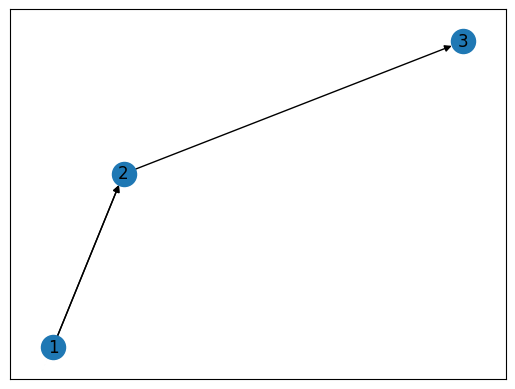

In [11]:
# Cell 10: Observations & Visualization

import matplotlib.pyplot as plt

def visualize_subgraph(subgraph):
    plt.figure(figsize=(8,6))
    pos = nx.spring_layout(subgraph)
    nx.draw_networkx_nodes(subgraph, pos, node_size=500)
    nx.draw_networkx_edges(subgraph, pos)
    nx.draw_networkx_labels(subgraph, pos)
    plt.show()

# ...

import time

# Create an instance
tcg = TemporalCausalGraph()

# Suppose we have observed a scenario: Node 1 is often followed by Node 2...
tcg.add_temporal_edge(source_id=1, target_id=2, time_delta=15.0, pattern_strength=0.8)
tcg.add_temporal_edge(source_id=1, target_id=2, time_delta=14.0, pattern_strength=0.9)
tcg.add_temporal_edge(source_id=2, target_id=3, time_delta=30.0, pattern_strength=0.6)

# Print out patterns
tcg.print_patterns()

# Recurring Patterns
recurring = tcg.identify_recurring_patterns(minimum_count=2, strength_threshold=0.5)
print("\nRecurring Patterns: ", recurring)

# Predictions
predictions = tcg.predict_likely_nodes(current_time=time.time(), temporal_context={})
print("\nPredicted Next Nodes: ", predictions)

pos = nx.spring_layout(tcg)
nx.draw_networkx_nodes(tcg, pos)
nx.draw_networkx_edges(tcg, pos)
nx.draw_networkx_labels(tcg, pos)
plt.show()

In [12]:
tcg.print_patterns()

1->2: strength=0.85, count=2, typical_time_delta=14.50
2->3: strength=0.60, count=1, typical_time_delta=30.00
